# Flowline mapping of a polymer sample

This tutorial demonstrates the flowline mapping and orientation correlation parts of py4DSTEM.diffraction.

### Tutorial data

[dataset19_bin4.h5](https://drive.google.com/file/d/1lK-TAMXN1MpWG0Q3_4vss_uEZgW2_Xh7/view?usp=sharing) (890 MB)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Alex Rakowski (arakowski@lbl.gov)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)

Data collected by Yael Tsarfati (yaeltsa@stanford.edu).


In [1]:
import py4DSTEM
print(py4DSTEM.__version__)

0.13.6


In [2]:
# file_data = r'C:\data\4DSTEM\tutorial\dataset19_bin4.h5'
# file_analysis = r'C:\data\4DSTEM\tutorial\dataset19_analysis_'
file_data = '/media/cophus/DataSSD1/data/dataset19_bin4.h5'
file_analysis = '/media/cophus/DataSSD1/data/dataset19_analysis_'

# Load data

In [3]:
py4DSTEM.io.print_h5_tree(file_data)

/
|--4DSTEM_experiment
	|--data
	|	|--coordinates
	|	|--counted_datacubes
	|	|--datacubes
	|	|	|--datacube_0
	|	|--diffractionslices
	|	|--pointlistarrays
	|	|--pointlists
	|	|--realslices
	|--metadata
		|--calibration
		|--comments
		|--microscope
		|--sample
		|--user




In [4]:
# This looks like an older py4DSTEM version - we will use the old syntax to read the file:
dataset = py4DSTEM.read(
    file_data,
    data_id = 'datacube_0',
)

In [5]:
# py4DSTEM.io.native.read_py4DSTEM?
# (file_data)

In [6]:
# dataset = py4DSTEM.read(
#     file_data, 
#     data_id = 'datacube_0'
# #     root = '4aDSTEM_experiment/data/datacubes/datacube_0'
# )

In [7]:
# import h5py

In [8]:
# f = h5py.File(file_data)

In [9]:
# dataset = py4DSTEM.io.DataCube(
#     data = f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['data'][:]
# )

In [10]:
dataset.data.shape

(180, 180, 60, 60)

# Virtual imaging 

In [11]:
dataset.get_dp_max()
dataset.get_dp_mean();

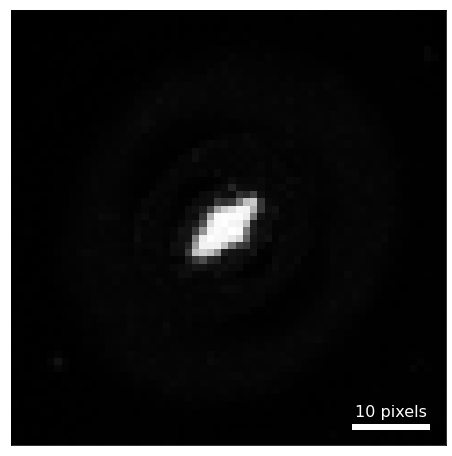

In [12]:
py4DSTEM.visualize.show(
    dataset.tree['dp_max'],
)

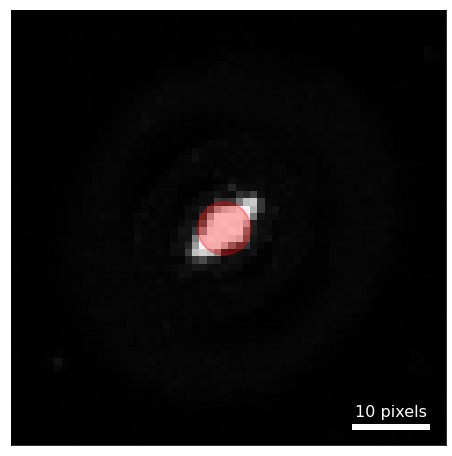

In [13]:
# Get approximate probe size (note this dataset has a lot of de-scan)

qr, qx, qy = py4DSTEM.process.calibration.get_probe_size(
    dataset.tree['dp_max'].data,
)
py4DSTEM.visualize.show_circles(
    dataset.tree['dp_max'], 
    (qx, qy), 
    qr, 
    figsize=(8,8),
)

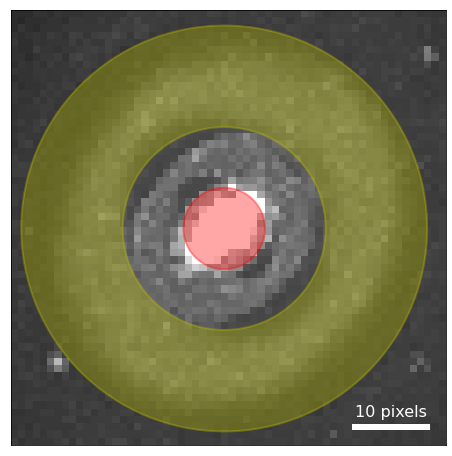

In [14]:
expand_BF = 2
det_DF = (14,28)
center = (qx,qy)

# Show selected virtual detectors
py4DSTEM.visualize.show(
    dataset.tree['dp_max'], 
    clipvals='manual',
    vmin=0,
    vmax=200,
    scaling='power',
    power=0.5,
    cmap='gray',
    circle={'R':qr + expand_BF,
             'center':center,
             'fill':True,
             'color':'r',
             'alpha':0.35},
    annulus={'radii':det_DF,
             'center':center,
             'fill':True,
             'color':'y',
             'alpha':0.35}
)

In [15]:
# Calculate both virtual images
dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center, qr + expand_BF),
    name = 'bright_field'
);
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center, det_DF),
    name = 'dark_field'
);

100%|██████████████████████████████████████████████████████████████████████████| 32400/32400 [00:00<00:00, 42578.38it/s]


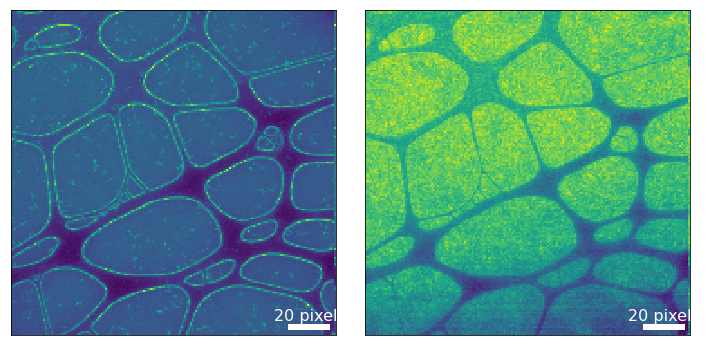

In [16]:
# Show the BF and DF images
py4DSTEM.visualize.show_image_grid(
    lambda i:[
        dataset.tree['bright_field'], 
        dataset.tree['dark_field'], 
    ][i],
    H=1,W=2,
    axsize=(5,5),
    cmap='viridis')

# Disk detection

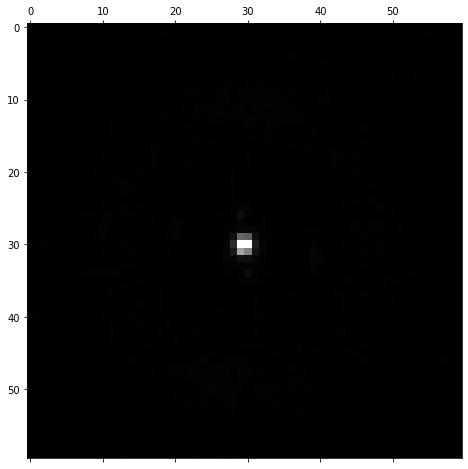

In [17]:
# This dataset has been so downsampled that we won't bother with a vacuum probe measurement.
# Instead we will use a synthetic probe kernel.

py4DSTEM.visualize.show(
    dataset.data[49,49],
    clipvals='manual',
    vmin=0,
    vmax=1000,
)

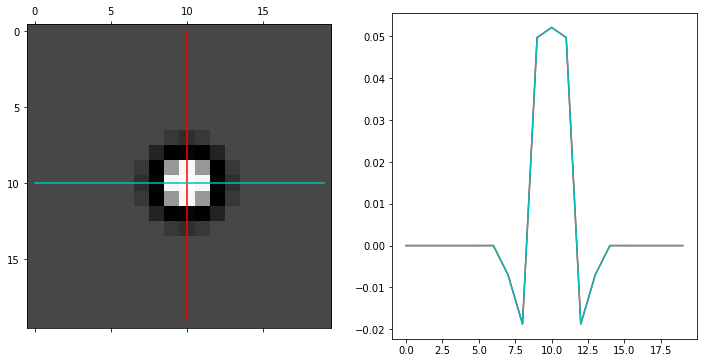

In [18]:
# Synthetic probe kernel
probe_radius = 1.5
probe_width = 1.0

probe_synthetic = py4DSTEM.process.probe.get_probe_synthetic(
    probe_radius,
    probe_width,
    dataset.Q_Nx,
    dataset.Q_Ny,
)

# # Subtract the normalization template, using a sine_squared kernel to localize the template
# probe_kernel = py4DSTEM.process.probe.get_probe_kernel(
#     probe_synthetic,
# )
# Subtract the normalization template, using a sine_squared kernel to localize the template
probe_kernel = py4DSTEM.process.probe.get_probe_kernel_edge_sigmoid(
    probe_synthetic, 
    (probe_radius * 0.0,probe_radius * 2.5),
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=10, L=10, W=1)

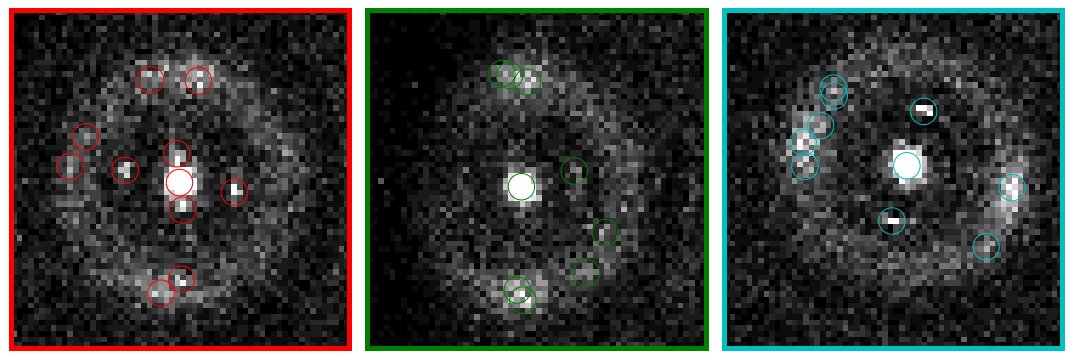

In [19]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

# rxs = 32,96,96
# rys = 32,32,96
rxs = 49,176,8
rys = 49,82, 147
colors=['r','g','c']


# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 4,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 1,
    'minPeakSpacing': 1,
    'subpixel' : 'poly',
#     'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=1, 
    W=3,
    axsize=(5,5),
    clipvals='manual',
    vmin=0,
    vmax=20,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)


In [20]:
# Find Bragg peaks for all probe positions
bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████████| 32.4k/32.4k [01:21<00:00, 396DP/s]


In [21]:
# Save Bragg disk locations
file_name_braggdisks_raw = file_analysis + 'braggdisks_raw.h5'

In [22]:
# Save Bragg disk positions
py4DSTEM.save(
    file_name_braggdisks_raw,
    bragg_peaks,
    mode='o',
)

100%|███████████████████████████████████████████████████████████████████████████| 32400/32400 [00:05<00:00, 5636.18it/s]


# Center Bragg peaks

In [23]:
# reload Bragg peaks if needed
file_name_braggdisks_raw = file_analysis + 'braggdisks_raw.h5'
py4DSTEM.print_h5_tree(file_name_braggdisks_raw)

/
|--4DSTEM
	|--braggvectors
		|--_v_uncal
		|--calibration




In [24]:
bragg_peaks = py4DSTEM.read(
    file_name_braggdisks_raw, 
    root = '4DSTEM/braggvectors'
#     data_id='braggpeaks_raw'
)
bragg_peaks

Reading PointListArray: 100%|████████████████████████████████████████████| 32400/32400 [00:05<00:00, 5879.20PointList/s]


BraggVectors( A (180, 180)-shaped array of lists of bragg vectors )

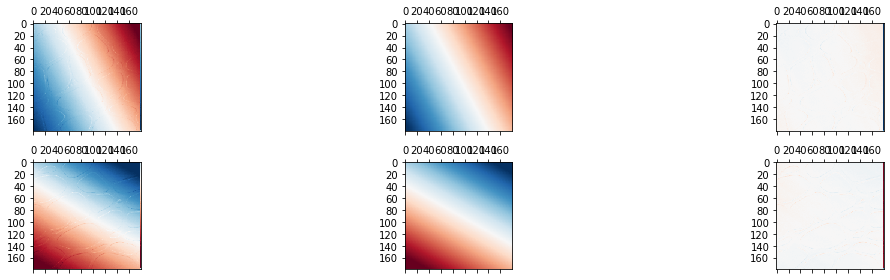

In [25]:
qxy_origins = bragg_peaks.measure_origin(
    mode = 'no_beamstop',
)

# Fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin(
    plot_range=3,
    fitfunction='Bezier_two',
)

In [26]:
# apply the centering calibration
bragg_peaks.calibration.set_origin((qx0_fit, qy0_fit))
bragg_peaks.calibrate()

# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm()

# Calibrate ellipticity

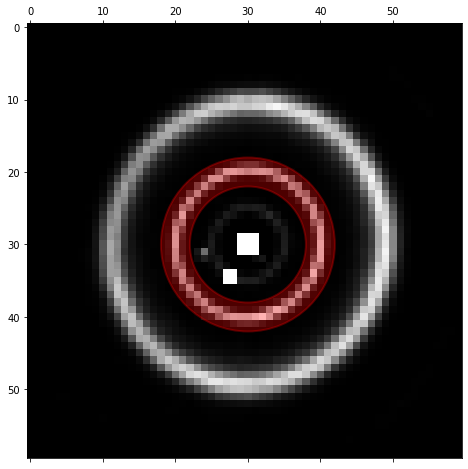

In [27]:
q_range = (8, 12)

py4DSTEM.show(
    bragg_vector_map_centered,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e3,
    annulus={
        'center':(bragg_vector_map_centered.shape[0]/2,bragg_vector_map_centered.shape[1]/2),
        'radii': q_range,'fill':True,'color':'r','alpha':0.3})

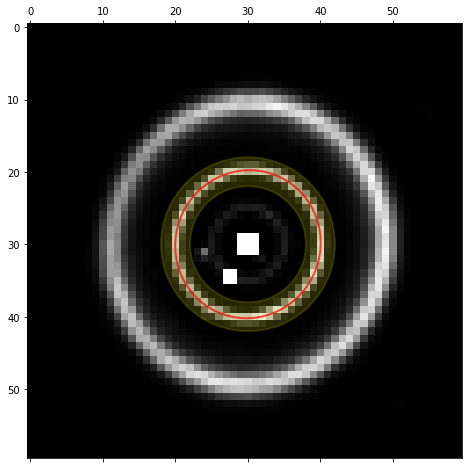

In [28]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
    bragg_vector_map_centered,
    fitradii = q_range,
)

# plot the fit
py4DSTEM.visualize.show_elliptical_fit(
    bragg_vector_map_centered,
    q_range,
    p_ellipse,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e3,
)

In [29]:
# Apply the elliptic calibrations
bragg_peaks.calibration.set_p_ellipse(p_ellipse)
bragg_peaks.calibrate()

# Visualizing orientations with flowline images

In [30]:
# Compute the elliptically corrected BVM
bragg_vector_map_cali = bragg_peaks.get_bvm()

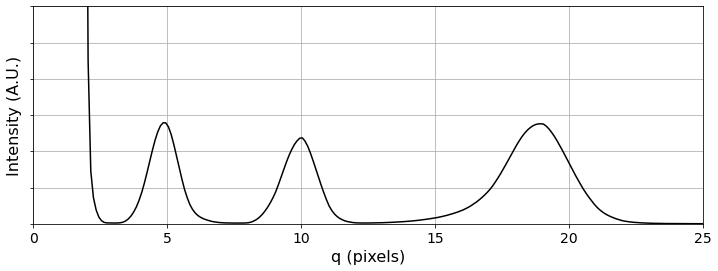

In [31]:
# Radial integration - we will use this plot to select diffraction rings to plot

ymax = 3e5

q,I_radial = py4DSTEM.process.utils.radial_integral(
    bragg_vector_map_cali,
)
fig,ax = py4DSTEM.visualize.show_qprofile(
    q=q,
    intensity=I_radial,
    ymax=ymax,
    returnfig=True,
)
ax.set_xlim([0, 25]);

In [32]:
# Generate orientation histogram.
# Note that for now we will skip the center-most ring, since we can see strong false positives in the BVM.

radial_ranges = [
    [8, 12],
    [15, 23],
]

orient_hist = py4DSTEM.process.diffraction.make_orientation_histogram(
    bragg_peaks.vectors,
    radial_ranges,
    upsample_factor=4,
)

Generating histogram 1: 100%|█████████████████████████████████████| 32400/32400 [00:05<00:00, 5722.81 probe positions/s]


Interpolating orientation matrices ... done.


In [33]:
orient_hist.shape

(2, 720, 720, 180)

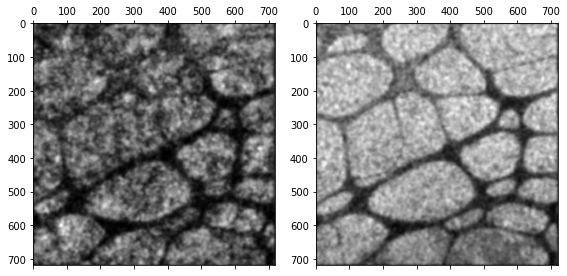

In [34]:
# Let's plot the total signals in each orientation matrix
py4DSTEM.visualize.show_image_grid(
    lambda i:orient_hist[i].sum(axis=2),
    H=1,
    W=2,
    cmap='gray',
    axsize=(4,4),
)

In [35]:
# Generate flowline arrays
orient_flowlines = py4DSTEM.process.diffraction.make_flowline_map(
    orient_hist,
)

Drawing flowlines 1: 100%|███████████████████████████████████████████████████| 34032/34032 [01:20<00:00, 425.03 seeds/s]


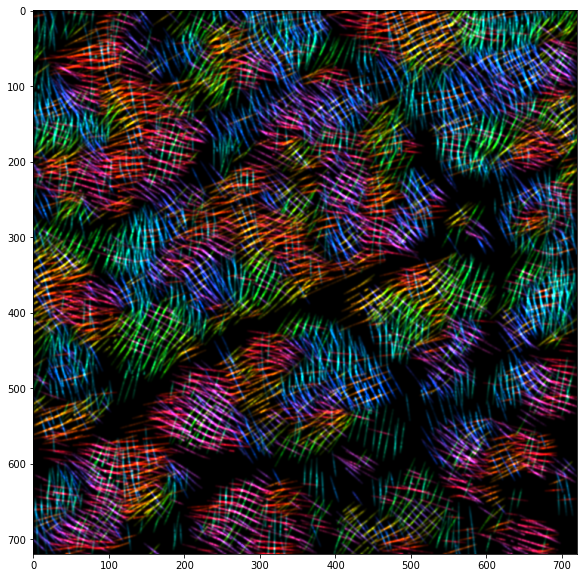

In [36]:
# Draw flowline images, where each plane is colored by its orientation

im_flowline_01 = py4DSTEM.process.diffraction.make_flowline_rainbow_image(
    orient_flowlines,
    int_range=[0,0.1],
    greyscale=False,
    white_background=False,
    plot_images=True,
    sum_radial_bins=True,
)

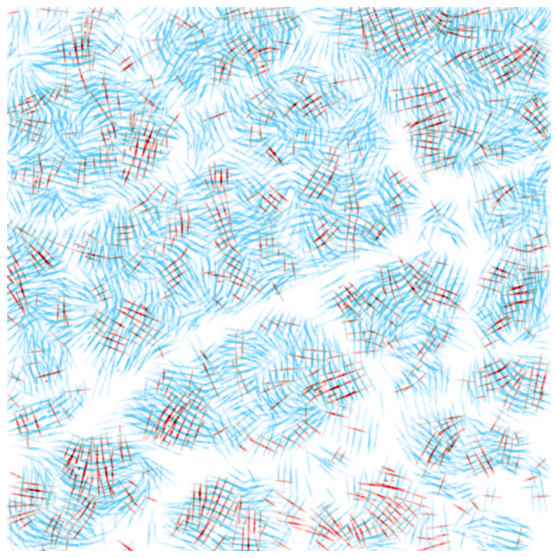

In [37]:
# Draw flowline images coloured by the radial ring the diffraction spots came from

im_flowline_02 = py4DSTEM.process.diffraction.make_flowline_combined_image(
    orient_flowlines,
    int_range=[0,0.1],
    cvals = [
        [1.0,0.0,0.0],
        [0.4,0.8,1.0],
        ],
    plot_images=True,
    white_background=True,
    sum_radial_bins=True,
)

# Correlation plots

In [38]:
# Remake the histogram with less upsampling
orient_hist_upsample_2 = py4DSTEM.process.diffraction.make_orientation_histogram(
    bragg_peaks.vectors,
    radial_ranges,
    upsample_factor=2,
)

Generating histogram 1: 100%|█████████████████████████████████████| 32400/32400 [00:04<00:00, 7331.70 probe positions/s]


Interpolating orientation matrices ... done.


In [39]:
orient_corr = py4DSTEM.process.diffraction.orientation_correlation(
    orient_hist_upsample_2,
    radius_max=50, 
)

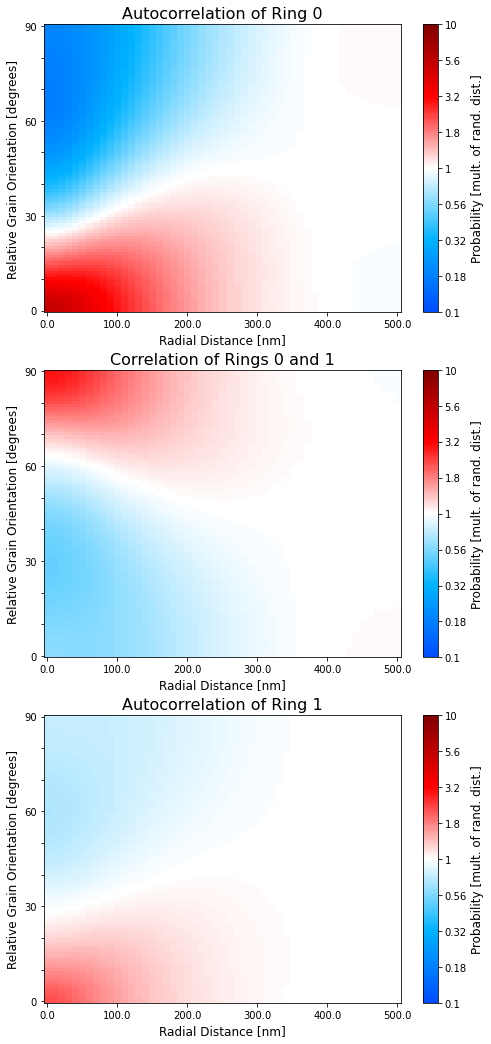

In [40]:
fig,ax = py4DSTEM.process.diffraction.plot_orientation_correlation(
    orient_corr,
    prob_range=[0.1,10.0],
#     inds_plot=3,#[0,3,5],
    pixel_size=20/2,
    pixel_units='nm',
    return_fig=True
)

In [41]:
orient_corr.shape

(3, 91, 51)